# How much did the $>50$ keV electrons contribute to the atmospheric energy flux?

In [1]:
import string

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors
import numpy as np
import pandas as pd

import elfinasi

c:\Users\shumkms1\AppData\Local\anaconda3\envs\asilib_dev_20241108\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
time_range = ('2022-09-04T04:18:00', '2022-09-04T04:23:00')
kev_erg_factor = 1.6E-9  # The conversion factor from KeV to ergs.
precipitation_solid_angle = 2*np.pi

## Load ELFIN and ASI inversion data

In [3]:
pad_obj_eflux = elfinasi.EPD_PAD(
    'a', time_range, start_pa=0, min_counts=None, accumulate=1, spin_time_tol=(2.5, 12),
    lc_exclusion_angle=10, nflux=False
)

C:\Users\shumkms1\Documents\research\elfinasi\src\elfinasi\elfin.py:839: UserWarning: The BLC/DLC ratios are all NaNs. This could be due to the lc_exclusion_angle excluding all pitch angles sampled.
  warnings.warn(


The THEMIS ASI inversion values were derived using the [Gabrielse+2021](https://doi.org/10.3389/fphy.2021.744298) algorithm.

In [4]:
themis_asi_eflux = pd.read_csv(
    elfinasi.data_dir / '20220904_themis_asi_inversion.csv', index_col=0, parse_dates=True, na_values=('NaN', "-1")
)

In [5]:
themis_asi_eflux.head()

,PINALat,GILLlat,ClosestStation,Elevation [deg],ELFINeflux [erg/cm^2/s],ELFINenergy [keV]
date/time,,,,,,
2022-09-04 04:17:00,61.1741,67.0371,pina,NaN,NaN,NaN
2022-09-04 04:17:01,61.1741,67.0371,pina,NaN,NaN,NaN
2022-09-04 04:17:02,61.1741,67.0371,pina,NaN,NaN,NaN
2022-09-04 04:17:03,61.1741,67.0371,pina,NaN,NaN,NaN
2022-09-04 04:17:04,61.1741,67.0371,pina,NaN,NaN,NaN


## Plot the ELFIN BLC and ABLC energy fluxes
Let's compare the amount of energy flux that disspiated in the atmosphere vs the amount that made it back out.

C:\Users\shumkms1\AppData\Local\Temp\ipykernel_28796\1964764843.py:19: RuntimeWarning: divide by zero encountered in divide
  pad_obj_eflux.blc.T/pad_obj_eflux.ablc.T,
C:\Users\shumkms1\AppData\Local\Temp\ipykernel_28796\1964764843.py:19: RuntimeWarning: invalid value encountered in divide
  pad_obj_eflux.blc.T/pad_obj_eflux.ablc.T,


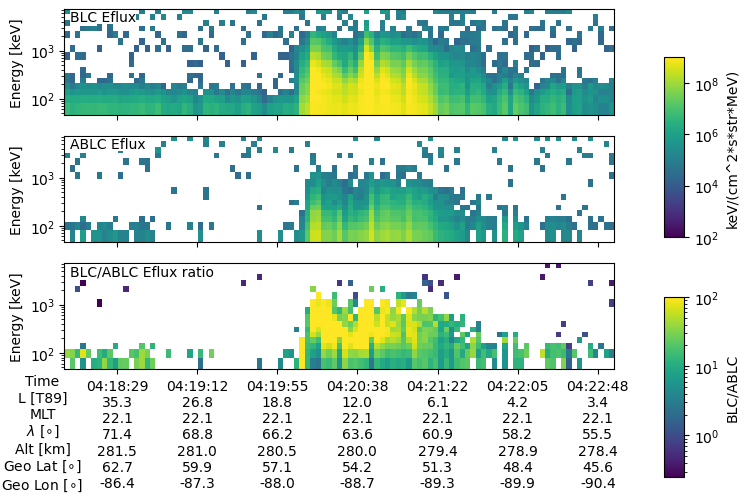

In [6]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
p = ax[0].pcolormesh(
            pad_obj_eflux.pad.time, 
            pad_obj_eflux.energy, 
            pad_obj_eflux.blc.T,
            shading='nearest',
            norm=matplotlib.colors.LogNorm(vmin=1E2, vmax=1E9)
            )
p2 = ax[1].pcolormesh(
            pad_obj_eflux.pad.time, 
            pad_obj_eflux.energy, 
            pad_obj_eflux.ablc.T,
            shading='nearest',
            norm=matplotlib.colors.LogNorm(vmin=1E2, vmax=1E9)
            )
p3 = ax[2].pcolormesh(
            pad_obj_eflux.pad.time, 
            pad_obj_eflux.energy, 
            pad_obj_eflux.blc.T/pad_obj_eflux.ablc.T,
            shading='nearest',
            norm=matplotlib.colors.LogNorm(vmax=10**2)
            )

pad_obj_eflux.plot_position(ax[-1])

labels = ('BLC Eflux', 'ABLC Eflux', 'BLC/ABLC Eflux ratio')
for ax_i, label in zip(ax, labels):
    ax_i.set_yscale('log')
    ax_i.set_ylabel('Energy [keV]')
    _text = ax_i.text(0.01, 0.99, label, transform=ax_i.transAxes, va='top')
    _text.set_bbox(dict(facecolor='white', linewidth=0, pad=0.1, edgecolor='k'))

fig.subplots_adjust(left=0.25, right=0.8)
cbar_ax0 = fig.add_axes([0.85, 0.5, 0.02, 0.3])
cbar_ax1 = fig.add_axes([0.85, 0.1, 0.02, 0.3])
fig.colorbar(p, cax=cbar_ax0, label=pad_obj_eflux._flux_units)
fig.colorbar(p3, cax=cbar_ax1, label='BLC/ABLC')

ax[-1].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[-1].xaxis.set_label_coords(-0.04, -0.007*7)
ax[-1].xaxis.label.set_size(10)


The bottom panel shows us that typically the precipitating energy flux was 10x-100x of the energy flux going back up. In other words, the $>50$ keV energy flux was mostly deposited into the atmosphere.

## What was the integrated $>50$ keV energy flux that ELFIN observed?

In [7]:
energy_widths_mev = (pad_obj_eflux.energy_widths[:, 1]-pad_obj_eflux.energy_widths[:, 0])/1E3
eflux_ergs = kev_erg_factor*precipitation_solid_angle*(pad_obj_eflux.blc - pad_obj_eflux.ablc)*energy_widths_mev
relativistic_eflux = np.nansum(eflux_ergs, axis=1)

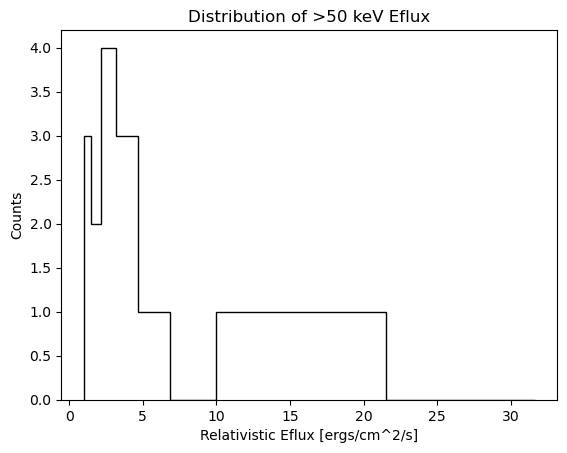

In [8]:
plt.hist(relativistic_eflux, bins=np.logspace(0, 1.5, 10), histtype='step', color='k')
plt.title('Distribution of >50 keV Eflux')
plt.xlabel('Relativistic Eflux [ergs/cm^2/s]')
plt.ylabel('Counts');

Looks good! Now let's merge the ELFIN and THEMIS-ASI Eflux values on the same time stamps and calculate the percentage contribution of the >50 keV electrons to the total energy flux

In [9]:
elfin_eflux = pd.DataFrame(relativistic_eflux, index=pad_obj_eflux.pad.time, columns=['energetic'])
auroral_eflux = pd.DataFrame(themis_asi_eflux['ELFINeflux [erg/cm^2/s]']).rename(columns={'ELFINeflux [erg/cm^2/s]':'auroral'})

merged_eflux = pd.merge_asof(
    elfin_eflux, 
    auroral_eflux, 
    left_index=True, 
    right_index=True, 
    direction='nearest', 
    tolerance=pd.Timedelta('1s')
    )
merged_eflux['energetic_contribution'] = 100*merged_eflux['energetic']/(merged_eflux['auroral'] + merged_eflux['energetic'])

In [10]:
merged_eflux

,energetic,auroral,energetic_contribution
2022-09-04 04:18:01.896945,0.006678,NaN,NaN
2022-09-04 04:18:04.762952,0.001689,NaN,NaN
2022-09-04 04:18:07.659442,0.001947,NaN,NaN
2022-09-04 04:18:10.525450,0.002996,NaN,NaN
2022-09-04 04:18:13.421940,0.004960,NaN,NaN
...,...,...,...
2022-09-04 04:22:44.012952,-0.003151,0.099598,-3.267087
2022-09-04 04:22:46.887953,0.002618,0.133913,1.917585
2022-09-04 04:22:49.784443,0.001415,NaN,NaN
2022-09-04 04:22:52.650450,-0.002075,NaN,NaN


In [11]:
merged_eflux.dropna().describe().round(3)

,energetic,auroral,energetic_contribution
count,64.000,64.000,64.000
mean,1.131,6.393,8.783
std,2.937,9.894,13.560
min,-0.005,0.044,-5.728
25%,0.002,0.133,1.053
50%,0.013,0.493,4.266
75%,0.924,13.337,10.810
max,18.236,30.025,68.381


Note: the negative min energetic EFlux is a result of the space-time aliasing, with higher fluxes in the ABLC than the BLC during the ELFIN half-spin period

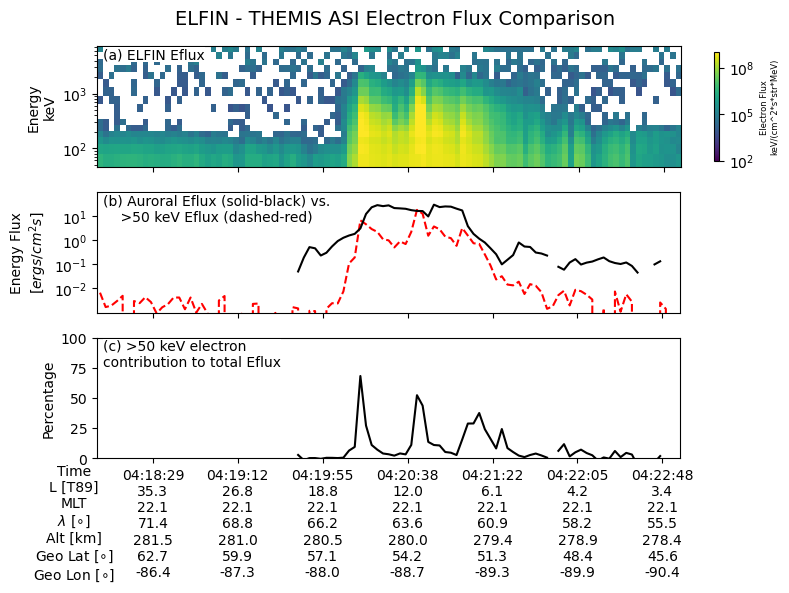

In [12]:
fig, bx = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
pad_obj_eflux.plot_omni(bx[0], labels=True, colorbar=True, vmin=1E2, vmax=1E9, pretty_plot=False, fraction=0.05)
bx[1].plot(
    merged_eflux.index, 
    merged_eflux['energetic'], 
    label='>50 keV Eflux (BLC-ABLC)', 
    color='r', 
    linestyle='--'
    )
bx[1].plot(
    merged_eflux.index, 
    merged_eflux['auroral'], 
    label='THEMIS ASI Eflux', color='k'
    )

bx[2].plot(merged_eflux.index, merged_eflux['energetic_contribution'], color='k')
pad_obj_eflux.plot_position(bx[-1])
bx[-1].xaxis.set_major_locator(plt.MaxNLocator(7))
bx[-1].xaxis.set_label_coords(-0.04, -0.007*7)
bx[-1].xaxis.label.set_size(10)

for bx_i in bx[[1, 2]]:
    divider = make_axes_locatable(bx_i)
    cax = divider.append_axes("right", size="10%", pad=0.08)
    cax.remove()

bx[1].set_yscale('log')
bx[1].set_ylabel(f'Energy Flux\n$[ergs/cm^{{2}}s]$')
bx[1].set_yticks([1E-2, 1E-1, 1E0, 1E1])
bx[1].set_ylim(1E-3, 1E2)

bx[2].set_ylabel(f'Percentage')
bx[2].set_ylim(0, 1E2)

labels = (
    'ELFIN Eflux', 
    'Auroral Eflux (solid-black) vs.\n    >50 keV Eflux (dashed-red)', 
    '>50 keV electron\ncontribution to total Eflux'
    )
for ax_i, label, letter in zip(bx, labels, string.ascii_lowercase):
    _text = ax_i.text(0.01, 0.99, f'({letter}) {label}', transform=ax_i.transAxes, va='top')
    _text.set_bbox(dict(facecolor='white', linewidth=0, pad=0.1, edgecolor='k'))
plt.suptitle('ELFIN - THEMIS ASI Electron Flux Comparison', fontsize=14)
plt.tight_layout()

Not a bad comparison considering that the [Gabrielse+2021](https://doi.org/10.3389/fphy.2021.744298) inversion for this event did not include the MSP data (those instruments stopped operating then). We should compare this with Calgary's inversion.

Two lessons learned from this first comparison:
1. Typically the energetic energy fluxes make up a small portion (4% median and 8% percent mean), and
2. Occasionally the energetic energy fluxes can make up as much as 68% of the energetic+auroral energy flux.